In [ ]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle

# !kaggle datasets download -d aadeepaggarwal/df-raw-fydp

# import zipfile
# import os

# with zipfile.ZipFile("C:\Users\aadee\OneDrive\Desktop\GLOF Final\prepared_dataset.zip", 'r') as zip_ref:
#     zip_ref.extractall("data")

In [ ]:
import pandas as pd
mydf = pd.read_csv("C:\Users\aadee\OneDrive\Desktop\GLOF Final\prepared_dataset.csv", usecols=["lat", "lon", "mid_date", "v [m/yr]"])

In [3]:
import pandas as pd

# First ensure mid_date is a datetime type (if it isn't already)
mydf['mid_date'] = pd.to_datetime(mydf['mid_date'])

# Filter for dates between 2000-01-01 and 2021-12-31
filtered_df = mydf[(mydf['mid_date'] >= '2000-01-01') & (mydf['mid_date'] <= '2021-12-31')]

# Display the filtered data
print(f"Original data points: {len(mydf)}")
print(f"Filtered data points: {len(filtered_df)}")
filtered_df.head()

Original data points: 68146246
Filtered data points: 40994766


,mid_date,lon,lat,v [m/yr]
0,2009-10-30 05:25:25.862885888,74.353,36.25,23.0
1,2004-08-28 05:30:18.351895040,74.353,36.25,79.0
3,2021-08-08 05:46:39.210629120,74.353,36.25,5.0
4,2016-02-27 05:42:51.255436032,74.353,36.25,8.0
5,2011-06-09 17:27:53.216076032,74.353,36.25,94.0


In [4]:
df = filtered_df
df[(df["v [m/yr]"] == "2021-11-15")]

,mid_date,lon,lat,v [m/yr]


In [5]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging

# Set up logging to track training metrics
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

2025-03-01 03:40:05,165 - Using device: cuda


In [6]:
# Cell # 2
def load_and_preprocess_data(df):
    """
    Load and preprocess the dataset for a Transformer model.

    Parameters:
    - file_path (str): Path to the CSV file containing the dataset.

    Returns:
    - data (np.array): Preprocessed data with scaled features and target.
    - scaler_X (StandardScaler): Scaler for the features.
    - scaler_y (StandardScaler): Scaler for the target.
    """
    # Load the dataset from CSV
    df = df

    # Drop rows with missing values to ensure data quality
    df = df.dropna()

    # Convert mid_date to datetime
    df['mid_date'] = pd.to_datetime(df['mid_date'])

    # Convert datetime to an ordinal timestamp including time of day
    # Ordinal date + fractional day (hours, minutes, seconds as a fraction of 86400 seconds)
    df['ordinal'] = df['mid_date'].apply(
        lambda x: x.toordinal() + (x.hour * 3600 + x.minute * 60 + x.second) / 86400.0
    )

    # Define features and target
    features = ['ordinal', 'lat', 'lon']
    target = 'v [m/yr]'

    # Extract feature and target arrays
    X = df[features].values
    y = df[target].values

    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    print(X_scaled[:10])


    # Scale target
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    print(y_scaled[:10])
    # Combine scaled features and target into a single array
    data = np.hstack((X_scaled, y_scaled))

    print(f"Preprocessed data shape: {data.shape}")
    print(data[:2])
    return data, scaler_X, scaler_y

In [7]:
# Cell 3: Define the TimeSeriesDataset class
class TimeSeriesDataset(Dataset):
    """Custom Dataset for time series data."""
    def __init__(self, data, seq_length):
        self.data = data.astype(np.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        """Return sequence of features and target."""
        X = self.data[idx:idx + self.seq_length, :-1]  # All features except target
        y = self.data[idx + self.seq_length - 1, -1]   # Last velocity value in sequence
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [8]:
# Cell 4: Define the Transformer model
class TransformerRegressor(nn.Module):
    """Transformer model for velocity prediction."""
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))  # Positional encoding
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        """Forward pass through the model."""
        batch_size, seq_len, _ = x.size()
        x = self.embedding(x)  # [batch_size, seq_len, d_model]
        x = x + self.pos_encoder[:, :seq_len, :]  # Add positional encoding
        x = self.transformer_encoder(x)  # [batch_size, seq_len, d_model]
        x = self.fc(x[:, -1, :])  # Predict from last time step
        return x

In [9]:
# Cell 5: Training function with metric tracking
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def count_trainable_parameters(model):
    """
    Count and return the number of trainable parameters in the model.
    
    Parameters:
    - model (nn.Module): The PyTorch model.
    
    Returns:
    - int: Number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs):
    """Train the model and track metrics."""
    # Print the number of trainable parameters before starting training
    trainable_params = count_trainable_parameters(model)
    print(f"Number of trainable parameters: {trainable_params}")
    
    # Lists to store metrics for plotting later
    train_losses, val_losses, val_maes = [], [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X, y in pbar_train:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            # Updated autocast syntax to kill that warning
            with torch.amp.autocast('cuda'):
                output = model(X)
                loss = criterion(output.squeeze(), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            # Show the batch loss in the progress bar
            pbar_train.set_postfix({'loss': loss.item()})

        # Average train loss for the epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss, val_mae = 0, 0
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for X, y in pbar_val:
                X, y = X.to(device), y.to(device)
                with torch.amp.autocast('cuda'):
                    output = model(X)
                loss = criterion(output.squeeze(), y)
                val_loss += loss.item()
                val_mae += torch.mean(torch.abs(output.squeeze() - y)).item()
                # Show batch loss and MAE in the progress bar
                pbar_val.set_postfix({'loss': loss.item(), 'MAE': val_mae / len(val_loader)})

        # Average val loss and MAE for the epoch
        val_loss /= len(val_loader)
        val_mae /= len(val_loader)
        val_losses.append(val_loss)
        val_maes.append(val_mae)

        # Print all the metrics after each epoch
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")

        # Step the scheduler based on val loss
        scheduler.step(val_loss)

    # Return the metrics for plotting or analysis
    return train_losses, val_losses, val_maes

In [10]:
torch.cuda.is_available()

True

In [ ]:
# Cell 6: Main execution
if __name__ == "__main__":
    # Hyperparameters (adjustable for experimentation)
    SEQ_LENGTH = 32       # Sequence length
    BATCH_SIZE = 2048         # Batch size
    NUM_EPOCHS = 50          # Number of epochs
    LEARNING_RATE = 0.0001    # Learning rate
    D_MODEL = 128            # Model dimension
    NHEAD = 8                # Number of attention heads
    NUM_LAYERS = 4           # Number of transformer layers
    DROPOUT = 0.2           # Dropout rate

    # Load and preprocess data
    # file_path = '/kaggle/input/df-raw-fydp/df_raw.csv'
    file_path = 'C:\Users\aadee\OneDrive\Desktop\GLOF Final\prepared_dataset.csv'

    data, scaler_X, scaler_y = load_and_preprocess_data(df)

    # Split data into train, validation, and test sets
    train_size = int(0.7 * len(data))
    val_size = int(0.2 * len(data))
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]

    # Create datasets and dataloaders
    train_dataset = TimeSeriesDataset(train_data, SEQ_LENGTH)
    val_dataset = TimeSeriesDataset(val_data, SEQ_LENGTH)
    test_dataset = TimeSeriesDataset(test_data, SEQ_LENGTH)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Initialize model, loss, optimizer, and scheduler
    model = TransformerRegressor(
        input_dim=3, d_model=D_MODEL, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    scaler = GradScaler()


[[-1.13170407 -1.21171553 -1.53647779]
 [-2.14260557 -1.21171553 -1.53647779]
 [ 1.16946014 -1.21171553 -1.53647779]
 [ 0.10504015 -1.21171553 -1.53647779]
 [-0.81730098 -1.21171553 -1.53647779]
 [-2.17257401 -1.21171553 -1.53647779]
 [-0.22461526 -1.21171553 -1.53647779]
 [ 0.69451262 -1.21171553 -1.53647779]
 [-1.50042199 -1.21171553 -1.53647779]
 [-1.45332853 -1.21171553 -1.53647779]]
[[ 0.09592376]
 [ 1.31282827]
 [-0.29522411]
 [-0.2300328 ]
 [ 1.63878484]
 [ 2.66011541]
 [-0.31695455]
 [-0.31695455]
 [-0.2300328 ]
 [-0.25176324]]
Preprocessed data shape: (40994766, 4)
[[-1.13170407 -1.21171553 -1.53647779  0.09592376]
 [-2.14260557 -1.21171553 -1.53647779  1.31282827]]


/tmp/ipykernel_15474/2729104912.py:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [12]:
print('done')

done


In [13]:
# Train the model
if(True):
    train_losses, val_losses, val_maes = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, NUM_EPOCHS
    )

Number of trainable parameters: 2500737


Epoch 1/50 [Val]: 100%|██████████| 4004/4004 [01:27<00:00, 45.52it/s, loss=1.18, MAE=0.397]  


Epoch 1/50 - Train Loss: 1.0111, Val Loss: 0.8696, Val MAE: 0.3969


Epoch 2/50 [Val]: 100%|██████████| 4004/4004 [01:27<00:00, 45.63it/s, loss=1.12, MAE=0.413] 


Epoch 2/50 - Train Loss: 0.9498, Val Loss: 0.8023, Val MAE: 0.4132


Epoch 3/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.40it/s, loss=0.909, MAE=0.399] 


Epoch 3/50 - Train Loss: 0.8711, Val Loss: 0.7067, Val MAE: 0.3993


Epoch 4/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.41it/s, loss=0.856, MAE=0.379] 


Epoch 4/50 - Train Loss: 0.7599, Val Loss: 0.6711, Val MAE: 0.3793


Epoch 5/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.20it/s, loss=1, MAE=0.369]     


Epoch 5/50 - Train Loss: 0.6698, Val Loss: 0.6532, Val MAE: 0.3688


Epoch 6/50 [Val]: 100%|██████████| 4004/4004 [01:27<00:00, 45.55it/s, loss=0.673, MAE=0.348] 


Epoch 6/50 - Train Loss: 0.6191, Val Loss: 0.5635, Val MAE: 0.3481


Epoch 7/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.45it/s, loss=0.763, MAE=0.335] 


Epoch 7/50 - Train Loss: 0.5819, Val Loss: 0.5620, Val MAE: 0.3347


Epoch 8/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.37it/s, loss=0.807, MAE=0.338] 


Epoch 8/50 - Train Loss: 0.5479, Val Loss: 0.5476, Val MAE: 0.3379


Epoch 9/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.38it/s, loss=0.749, MAE=0.327] 


Epoch 9/50 - Train Loss: 0.5188, Val Loss: 0.5092, Val MAE: 0.3266


Epoch 10/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.39it/s, loss=0.786, MAE=0.325] 


Epoch 10/50 - Train Loss: 0.4929, Val Loss: 0.5039, Val MAE: 0.3246


Epoch 11/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.31it/s, loss=0.628, MAE=0.327] 


Epoch 11/50 - Train Loss: 0.4718, Val Loss: 0.4948, Val MAE: 0.3269


Epoch 12/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.46it/s, loss=0.486, MAE=0.313] 


Epoch 12/50 - Train Loss: 0.4532, Val Loss: 0.4592, Val MAE: 0.3131


Epoch 13/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.15it/s, loss=0.628, MAE=0.324] 


Epoch 13/50 - Train Loss: 0.4373, Val Loss: 0.4920, Val MAE: 0.3242


Epoch 14/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.29it/s, loss=0.64, MAE=0.313]  


Epoch 14/50 - Train Loss: 0.4236, Val Loss: 0.4637, Val MAE: 0.3129


Epoch 15/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.44it/s, loss=0.782, MAE=0.3]   


Epoch 15/50 - Train Loss: 0.4112, Val Loss: 0.4428, Val MAE: 0.2999


Epoch 16/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.50it/s, loss=0.629, MAE=0.299] 


Epoch 16/50 - Train Loss: 0.4016, Val Loss: 0.4399, Val MAE: 0.2991


Epoch 17/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.31it/s, loss=0.717, MAE=0.312] 


Epoch 17/50 - Train Loss: 0.3926, Val Loss: 0.4589, Val MAE: 0.3120


Epoch 18/50 [Val]: 100%|██████████| 4004/4004 [01:27<00:00, 45.54it/s, loss=0.552, MAE=0.292] 


Epoch 18/50 - Train Loss: 0.3848, Val Loss: 0.4255, Val MAE: 0.2923


Epoch 19/50 [Val]: 100%|██████████| 4004/4004 [01:27<00:00, 45.55it/s, loss=0.625, MAE=0.3]   


Epoch 19/50 - Train Loss: 0.3780, Val Loss: 0.4225, Val MAE: 0.3001


Epoch 20/50 [Val]: 100%|██████████| 4004/4004 [01:27<00:00, 45.73it/s, loss=0.689, MAE=0.286] 


Epoch 20/50 - Train Loss: 0.3719, Val Loss: 0.4141, Val MAE: 0.2860


Epoch 21/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.39it/s, loss=0.674, MAE=0.289] 


Epoch 21/50 - Train Loss: 0.3657, Val Loss: 0.4172, Val MAE: 0.2892


Epoch 22/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.35it/s, loss=0.548, MAE=0.283] 


Epoch 22/50 - Train Loss: 0.3613, Val Loss: 0.4016, Val MAE: 0.2830


Epoch 23/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.32it/s, loss=0.541, MAE=0.281] 


Epoch 23/50 - Train Loss: 0.3567, Val Loss: 0.4054, Val MAE: 0.2814


Epoch 24/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.30it/s, loss=0.637, MAE=0.274] 


Epoch 24/50 - Train Loss: 0.3526, Val Loss: 0.4045, Val MAE: 0.2744


Epoch 25/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.17it/s, loss=0.634, MAE=0.292] 


Epoch 25/50 - Train Loss: 0.3484, Val Loss: 0.4315, Val MAE: 0.2919


Epoch 26/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.36it/s, loss=0.638, MAE=0.277] 


Epoch 26/50 - Train Loss: 0.3292, Val Loss: 0.3912, Val MAE: 0.2766


Epoch 27/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.27it/s, loss=0.644, MAE=0.273] 


Epoch 27/50 - Train Loss: 0.3252, Val Loss: 0.3880, Val MAE: 0.2725


Epoch 28/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.19it/s, loss=0.629, MAE=0.27]  


Epoch 28/50 - Train Loss: 0.3233, Val Loss: 0.3841, Val MAE: 0.2695


Epoch 29/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.33it/s, loss=0.672, MAE=0.27]  


Epoch 29/50 - Train Loss: 0.3222, Val Loss: 0.3861, Val MAE: 0.2704


Epoch 30/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.34it/s, loss=0.591, MAE=0.27]  


Epoch 30/50 - Train Loss: 0.3208, Val Loss: 0.3855, Val MAE: 0.2700


Epoch 31/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.38it/s, loss=0.652, MAE=0.272] 


Epoch 31/50 - Train Loss: 0.3199, Val Loss: 0.3885, Val MAE: 0.2720


Epoch 32/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.36it/s, loss=0.636, MAE=0.271] 


Epoch 32/50 - Train Loss: 0.3182, Val Loss: 0.3871, Val MAE: 0.2711


Epoch 33/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.30it/s, loss=0.639, MAE=0.269] 


Epoch 33/50 - Train Loss: 0.3177, Val Loss: 0.3851, Val MAE: 0.2693


Epoch 34/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.28it/s, loss=0.633, MAE=0.27]  


Epoch 34/50 - Train Loss: 0.3173, Val Loss: 0.3865, Val MAE: 0.2703


Epoch 35/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.36it/s, loss=0.632, MAE=0.27]  


Epoch 35/50 - Train Loss: 0.3171, Val Loss: 0.3867, Val MAE: 0.2704


Epoch 36/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.39it/s, loss=0.632, MAE=0.27]  


Epoch 36/50 - Train Loss: 0.3168, Val Loss: 0.3867, Val MAE: 0.2704


Epoch 37/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.43it/s, loss=0.63, MAE=0.271]  


Epoch 37/50 - Train Loss: 0.3167, Val Loss: 0.3872, Val MAE: 0.2707


Epoch 38/50 [Val]: 100%|██████████| 4004/4004 [01:27<00:00, 45.56it/s, loss=0.63, MAE=0.271]  


Epoch 38/50 - Train Loss: 0.3171, Val Loss: 0.3874, Val MAE: 0.2707


Epoch 39/50 [Val]: 100%|██████████| 4004/4004 [01:27<00:00, 46.01it/s, loss=0.63, MAE=0.271]  


Epoch 39/50 - Train Loss: 0.3171, Val Loss: 0.3875, Val MAE: 0.2708


Epoch 40/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.41it/s, loss=0.63, MAE=0.271]  


Epoch 40/50 - Train Loss: 0.3171, Val Loss: 0.3876, Val MAE: 0.2708


Epoch 41/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.00it/s, loss=0.63, MAE=0.271]  


Epoch 41/50 - Train Loss: 0.3168, Val Loss: 0.3876, Val MAE: 0.2708


Epoch 42/50 [Val]: 100%|██████████| 4004/4004 [01:26<00:00, 46.05it/s, loss=0.63, MAE=0.271]  


Epoch 42/50 - Train Loss: 0.3172, Val Loss: 0.3876, Val MAE: 0.2708


Epoch 43/50 [Val]: 100%|██████████| 4004/4004 [01:27<00:00, 45.54it/s, loss=0.63, MAE=0.271]  


Epoch 43/50 - Train Loss: 0.3170, Val Loss: 0.3877, Val MAE: 0.2708


Epoch 44/50 [Val]: 100%|██████████| 4004/4004 [01:27<00:00, 45.97it/s, loss=0.63, MAE=0.271]  


Epoch 44/50 - Train Loss: 0.3172, Val Loss: 0.3877, Val MAE: 0.2708


Epoch 45/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.33it/s, loss=0.63, MAE=0.271]  


Epoch 45/50 - Train Loss: 0.3169, Val Loss: 0.3878, Val MAE: 0.2709


Epoch 46/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.07it/s, loss=0.63, MAE=0.271]  


Epoch 46/50 - Train Loss: 0.3171, Val Loss: 0.3877, Val MAE: 0.2708


Epoch 47/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.11it/s, loss=0.63, MAE=0.271]  


Epoch 47/50 - Train Loss: 0.3171, Val Loss: 0.3878, Val MAE: 0.2709


Epoch 48/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.37it/s, loss=0.63, MAE=0.271]  


Epoch 48/50 - Train Loss: 0.3170, Val Loss: 0.3879, Val MAE: 0.2709


Epoch 49/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.30it/s, loss=0.63, MAE=0.271]  


Epoch 49/50 - Train Loss: 0.3170, Val Loss: 0.3878, Val MAE: 0.2709


Epoch 50/50 [Val]: 100%|██████████| 4004/4004 [01:28<00:00, 45.12it/s, loss=0.63, MAE=0.271]  

Epoch 50/50 - Train Loss: 0.3171, Val Loss: 0.3879, Val MAE: 0.2709


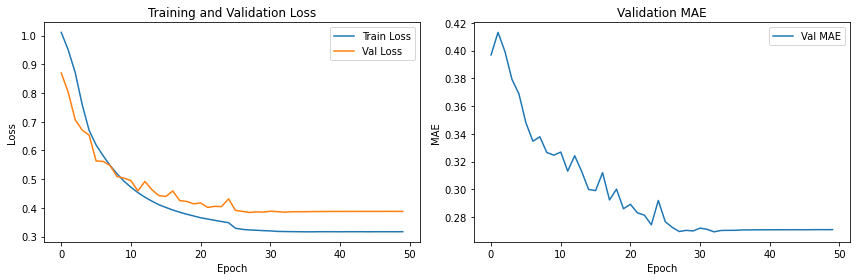

Testing: 100%|██████████| 2002/2002 [01:56<00:00, 17.11it/s]
2025-03-01 22:56:51,956 - Test Loss: 0.3689, Test MAE: 0.2618


In [15]:
if(True):
    # Cell 7: Plot training metrics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_maes, label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('Validation MAE')
    plt.tight_layout()
    plt.show()

    # Cell 8: Evaluate on test set
    model.eval()
    test_loss, test_mae = 0, 0
    with torch.no_grad():
        for X, y in tqdm(test_loader, desc="Testing"):
            X, y = X.to(device), y.to(device)
            output = model(X)
            test_loss += criterion(output.squeeze(), y).item()
            test_mae += torch.mean(torch.abs(output.squeeze() - y)).item()

    test_loss /= len(test_loader)
    test_mae /= len(test_loader)
    logger.info(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

In [16]:
    # Save the model
    torch.save(model.state_dict(), 'transformer_modelg.pth')
    logger.info("Model saved as 'transformer_model.pth'")

2025-03-01 22:56:52,007 - Model saved as 'transformer_model.pth'
